In [1]:
# --- 0) Imports & project path wiring ---
import sys, pathlib
root = pathlib.Path.cwd()
PROJ = None
for p in [root, *root.parents]:
    if (p / "src").exists():
        PROJ = p
        break
if PROJ is None:
    PROJ = root
SRC = PROJ / "src"
# Add the project ROOT to sys.path so 'src' is importable as a package
if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))
print("Using project root:", PROJ)

# Ensure we use the latest edits in src during interactive work
import importlib
import src.io_axona as _io_axona
importlib.reload(_io_axona)

from src.io_axona import find_session_files, load_pos_axona, load_units_t64, load_units_mclust
from src.analysis import (
    plot_arena,
    occupancy_map,
    center_mask,
    plot_coverage,
    rate_map,
    plot_rate_map,
    path_plus_spikes,
    ARENA_CM,
)
import matplotlib.pyplot as plt
import numpy as np


Using project root: c:\Users\ashar\OneDrive\Desktop\projects\ca1-tetrode-placemaps


In [2]:
# --- 1) Choose your session directory (exact path on your machine) ---
# Example:
# session_dir = PROJ / "data/Blackstad_CA1/24116/2018-04-05"
session_dir = PROJ / "data/Blackstad_CA1/24116/2018-04-05"
session_dir


WindowsPath('c:/Users/ashar/OneDrive/Desktop/projects/ca1-tetrode-placemaps/data/Blackstad_CA1/24116/2018-04-05')

In [3]:
# --- 2) Mention data files utilized (discover and list) ---
files = find_session_files(session_dir)
pos_file = files.get("pos")
set_file = files.get("set")
t64_list = files.get("t64_list", [])
tetrode_files = files.get("tetrodes", [])

print("Session:", session_dir)
print("  .pos:", pos_file)
print("  .set:", set_file)
print("  .t64 files:", len(t64_list))
for f in sorted(t64_list)[:8]:
    print("   -", f.name)
print("  .1–.8 tetrode files:", len(tetrode_files))
for f in sorted(tetrode_files)[:8]:
    print("   -", f.name)


Session: c:\Users\ashar\OneDrive\Desktop\projects\ca1-tetrode-placemaps\data\Blackstad_CA1\24116\2018-04-05
  .pos: c:\Users\ashar\OneDrive\Desktop\projects\ca1-tetrode-placemaps\data\Blackstad_CA1\24116\2018-04-05\2018-04-05.pos
  .set: c:\Users\ashar\OneDrive\Desktop\projects\ca1-tetrode-placemaps\data\Blackstad_CA1\24116\2018-04-05\2018-04-05.set
  .t64 files: 7
   - 2018-04-05_1_01.t64
   - 2018-04-05_1_02.t64
   - 2018-04-05_1_03.t64
   - 2018-04-05_1_04.t64
   - 2018-04-05_1_05.t64
   - 2018-04-05_1_06.t64
   - 2018-04-05_1_07.t64
  .1–.8 tetrode files: 4
   - 2018-04-05.1
   - 2018-04-05.2
   - 2018-04-05.3
   - 2018-04-05.4


In [4]:
# --- 3) Draw the .pos file (arena + trajectory) ---
pos_df = load_pos_axona(pos_file)
pos_df.head()



,t,x,y,ang,valid,speed,keep
0,0.00,180.000000,43.666667,NaN,1,97.182532,False
1,0.02,178.333333,44.666667,NaN,1,60.667582,False
2,0.04,177.666667,44.333333,NaN,1,18.633900,True
3,0.06,179.000000,44.333333,NaN,1,23.570226,True
4,0.08,177.000000,45.000000,NaN,1,60.092521,False


In [5]:
# === Display-normalize position to a 150 cm square and center it ===
import numpy as np

ARENA_CM = 150  # keep consistent with your analysis/plotting

def normalize_to_arena(df, arena_cm=ARENA_CM, pad_frac=0.0):
    """
    Non-destructive: returns a copy.
    1) Remove NaNs for range estimation
    2) Translate so min(x,y)=0
    3) Uniformly scale to fit inside [0, arena_cm] with optional padding
    4) Center in both axes
    """
    d = df.copy()
    x = d["x"].to_numpy(dtype=float)
    y = d["y"].to_numpy(dtype=float)
    m = np.isfinite(x) & np.isfinite(y)
    if not np.any(m):
        return d  # nothing to do

    x_min, x_max = float(np.nanmin(x[m])), float(np.nanmax(x[m]))
    y_min, y_max = float(np.nanmin(y[m])), float(np.nanmax(y[m]))
    xr, yr = (x_max - x_min), (y_max - y_min)
    if xr <= 0 or yr <= 0:
        return d

    # (1) zero-base
    d["x"] = d["x"] - x_min
    d["y"] = d["y"] - y_min

    # (2) uniform scale so the longer side fits, with optional padding
    usable = arena_cm * (1.0 - 2.0 * pad_frac)
    s = min(usable / xr, usable / yr)

    d["x"] = d["x"] * s
    d["y"] = d["y"] * s

    # (3) center inside the square
    new_xr = xr * s
    new_yr = yr * s
    x_off = (arena_cm - new_xr) / 2.0
    y_off = (arena_cm - new_yr) / 2.0
    d["x"] = d["x"] + x_off
    d["y"] = d["y"] + y_off

    # Optional: sanity print
    xmin, xmax = float(np.nanmin(d["x"])), float(np.nanmax(d["x"]))
    ymin, ymax = float(np.nanmin(d["y"])), float(np.nanmax(d["y"]))
    print(f"[normalize] x:[{xmin:.2f}, {xmax:.2f}]  y:[{ymin:.2f}, {ymax:.2f}]  scale:{s:.3f}")
    return d

# --- call it right after your loader ---
# pos_df = load_pos_axona(files["pos"])
pos_df = normalize_to_arena(pos_df, arena_cm=ARENA_CM, pad_frac=0.00)  # set 0.05 for 5% margins, if desired


[normalize] x:[1.35, 148.65]  y:[0.00, 150.00]  scale:1.160


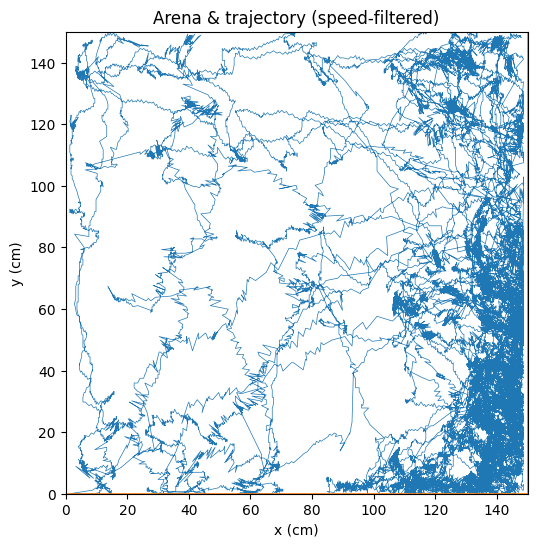

In [6]:
plot_arena(pos_df)


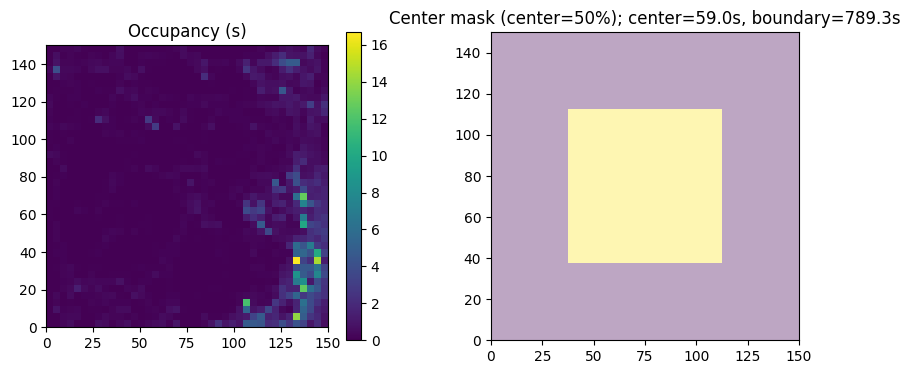

In [7]:
# --- 4) Divide arena into bins and show boundary & centre coverage ---
BINS = 40
plot_coverage(pos_df, bins=BINS, center_frac=0.5)


In [8]:
# --- 5) Load cluster cuts and pick a unit ---
# Prefer MClust .t/.t64 via local parser; fall back to MATLAB-based .t64
try:
    units = load_units_mclust(session_dir)
except Exception:
    units = {}
if not units:
    units = load_units_t64(session_dir)
print(f"Loaded {len(units)} units")
# Take the first unit for demonstration, or handle none
if units:
    (tet, clu), spike_ts = next(iter(units.items()))
    tet, clu, spike_ts[:10]
else:
    tet = clu = None
    spike_ts = np.array([])
    print("No units found; you can still run occupancy/coverage plots.")

Loaded 0 units
No units found; you can still run occupancy/coverage plots.


In [9]:
# --- 6) Spatial coverage map: rat movement + spike locations for this unit ---
if spike_ts.size:
    path_plus_spikes(pos_df, spike_ts)
else:
    print("Skipping spike overlay: no units found.")

Skipping spike overlay: no units found.


In [10]:
# --- 7) Firing-rate heatmap across space (place map) ---
if spike_ts.size:
    R = rate_map(pos_df, spike_ts, bins=BINS, sigma=1.0)
    plot_rate_map(R, title=f"T{tet} U{clu} — Rate map (Hz)")
else:
    print("Skipping rate map: no units found.")

Skipping rate map: no units found.


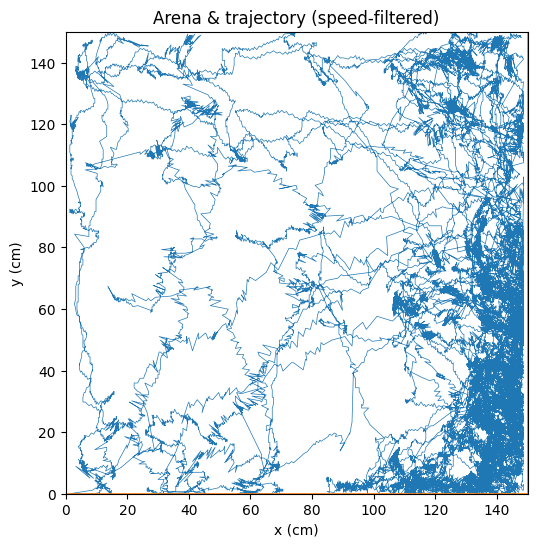

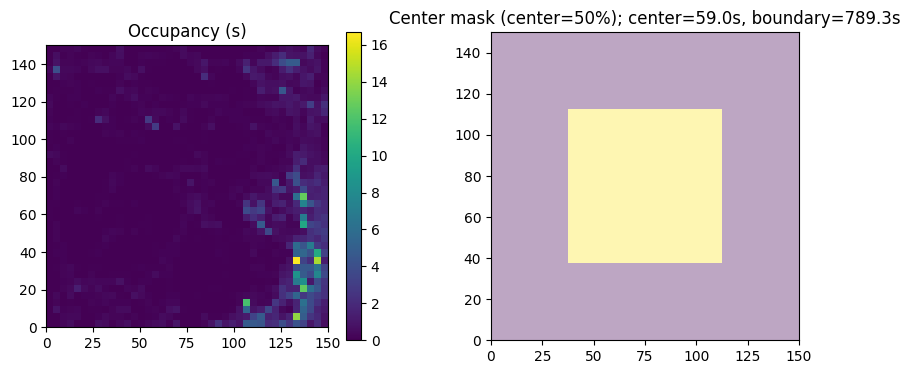

No units to export rate maps for.
Saved figures in: c:\Users\ashar\OneDrive\Desktop\projects\ca1-tetrode-placemaps\data\Blackstad_CA1\24116\2018-04-05\maps


In [11]:
# --- 8) Batch-generate and save all figures for this session ---
from pathlib import Path
outdir = session_dir / "maps"
outdir.mkdir(exist_ok=True)

# Arena & coverage
plot_arena(pos_df); plt.savefig(session_dir / "arena_path.png", dpi=200); plt.close()
plot_coverage(pos_df, bins=BINS, center_frac=0.5); plt.savefig(session_dir / "coverage.png", dpi=200); plt.close()

# Each unit (only if units available)
if units:
    for (tet, clu), spike_ts in units.items():
        path_plus_spikes(pos_df, spike_ts); plt.savefig(outdir / f"T{tet}_U{clu}_path_spikes.png", dpi=200); plt.close()
        R = rate_map(pos_df, spike_ts, bins=BINS, sigma=1.0)
        plt.figure(figsize=(5,5))
        plt.imshow(R, origin="lower", extent=[0,ARENA_CM,0,ARENA_CM])
        plt.title(f"T{tet} U{clu} — Rate map (Hz)")
        plt.colorbar(); plt.tight_layout()
        plt.savefig(outdir / f"T{tet}_U{clu}_ratemap.png", dpi=200); plt.close()
else:
    print("No units to export rate maps for.")

print("Saved figures in:", outdir)